In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pickle

import numpy as np

import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../scripts')
from utils import predict, predict_multi_line_text, load_data

sys.path.append('../')
from config import entity_to_acronyms, acronyms_to_entities

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ajaykarthicksenthilkumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ajaykarthicksenthilkumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# from importlib import reload

# import utils
# reload(utils)

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense

In [6]:
data_dir = '../data'
model_dir = '../models'

In [7]:
(train_sequences_padded, train_labels), (val_sequences_padded, val_labels), (test_sequences_padded, test_labels), label_to_index, index_to_label = load_data(data_dir)

train_sequences_padded.shape, train_labels.shape, val_sequences_padded.shape, val_labels.shape, test_sequences_padded.shape, test_labels.shape


((3038, 100),
 (3038, 100, 79),
 (434, 100),
 (434, 100, 79),
 (869, 100),
 (869, 100, 79))

In [8]:
if train_sequences_padded.shape[1] != train_labels.shape[1] or val_sequences_padded.shape[1] != val_labels.shape[1] or test_sequences_padded.shape[1] != test_labels.shape[1]:
    print('Sequence length mismatch')

In [9]:
# Load the tokenizer from file
with open('../data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [10]:
INPUT_DIM = len(tokenizer.word_index)
EMBEDDING_DIM = 216
NUM_CLASSES = len(label_to_index)
MAX_LENGTH = train_sequences_padded.shape[1]
LSTM_UNITS = 64
DROPOUT = 0.2
BATCH_SIZE = 32
EPOCHS = 20

In [11]:
train_sequences_padded.shape, train_labels.shape

((3038, 100), (3038, 100, 79))

train_sequences_padded is a 2D NumPy array with shape (3038, 100), which represents the padded training sequences. It has 3038 rows, where each row represents a sequence of maximum length 100 with padded zeros.

train_labels is a 3D NumPy array with shape (3038, 100, 79), which represents the one-hot encoded training labels. It has 3038 samples, 100 timesteps, and 79 classes (including the padding class).

## Building Model

In [12]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    _precision = true_positives / (predicted_positives + K.epsilon())
    return _precision

def recall(y_true, y_pred):
    """Compute recall metric"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    """Compute f1-score metric"""
    _precision = precision(y_true, y_pred)
    _recall = recall(y_true, y_pred)
    f1_score = 2 * ((_precision * _recall) / (_precision + _recall + K.epsilon()))
    return f1_score

In [32]:
# Define the model architecture
model = tf.keras.models.Sequential([
    Embedding(INPUT_DIM, EMBEDDING_DIM, input_length=MAX_LENGTH),
    Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True)),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1_score])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 216)          1496664   
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          143872    
 al)                                                             
                                                                 
 dense (Dense)               (None, 100, 79)           10191     
                                                                 
Total params: 1650727 (6.30 MB)
Trainable params: 1650727 (6.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# Train the model
history = model.fit(
    train_sequences_padded, 
    train_labels, 
    epochs=EPOCHS, 
    validation_data=(val_sequences_padded, val_labels)
)

Epoch 1/20
95/95 [==============================] - 8s 69ms/step - loss: 0.9347 - accuracy: 0.8740 - precision: 0.8322 - recall: 0.7331 - f1_score: 0.7786 - val_loss: 0.4358 - val_accuracy: 0.8992 - val_precision: 0.9923 - val_recall: 0.8692 - val_f1_score: 0.9266
Epoch 2/20
95/95 [==============================] - 6s 62ms/step - loss: 0.4051 - accuracy: 0.9060 - precision: 0.9999 - recall: 0.8684 - f1_score: 0.9294 - val_loss: 0.4240 - val_accuracy: 0.9037 - val_precision: 0.9892 - val_recall: 0.8714 - val_f1_score: 0.9266
Epoch 3/20
95/95 [==============================] - 6s 64ms/step - loss: 0.3796 - accuracy: 0.9076 - precision: 1.0000 - recall: 0.8740 - f1_score: 0.9327 - val_loss: 0.4162 - val_accuracy: 0.9044 - val_precision: 0.9864 - val_recall: 0.8750 - val_f1_score: 0.9273
Epoch 4/20
95/95 [==============================] - 6s 62ms/step - loss: 0.3448 - accuracy: 0.9131 - precision: 0.9985 - recall: 0.8864 - f1_score: 0.9390 - val_loss: 0.4003 - val_accuracy: 0.9090 - val_pr

In [34]:
import matplotlib.pyplot as plt

def plot_graphs(history):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend(['train', 'val'], loc='best')
    
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend(['train', 'val'], loc='best')
    
    axs[1, 0].plot(history.history['recall'])
    axs[1, 0].plot(history.history['val_recall'])
    axs[1, 0].set_title('Model Recall')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend(['train', 'val'], loc='best')
    
    axs[1, 1].plot(history.history['f1_score'])
    axs[1, 1].plot(history.history['val_f1_score'])
    axs[1, 1].set_title('Model F1 Score')
    axs[1, 1].set_ylabel('F1 Score')
    axs[1, 1].legend(['train', 'val'], loc='best')
    
    plt.tight_layout()
    plt.show()


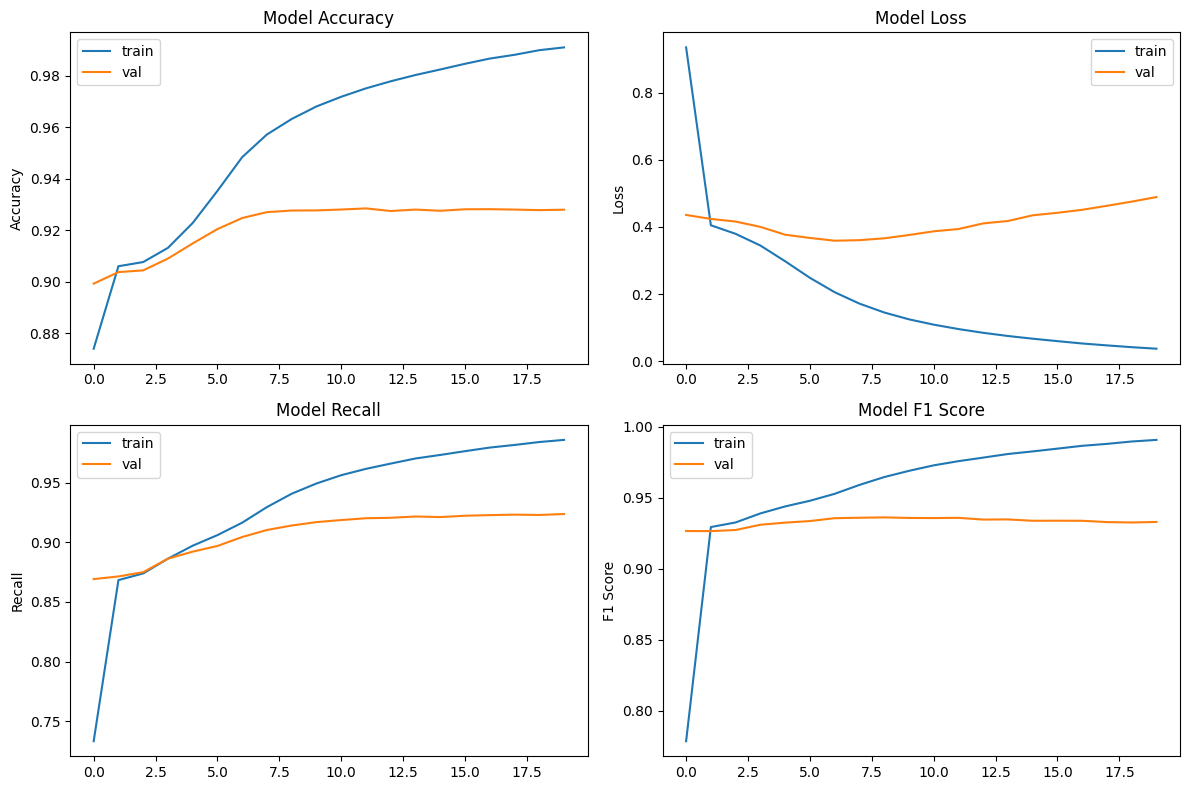

In [35]:
# Plot the training history
plot_graphs(history)

In [36]:
from sklearn.metrics import classification_report

# Get the model predictions
y_pred = model.predict(test_sequences_padded)

# Convert the predictions from one-hot encoded format to the label format
y_pred_labels = np.argmax(y_pred, axis=2)
test_labels_labels = np.argmax(test_labels, axis=2)

# Print the classification report
print(classification_report(test_labels_labels.reshape(-1), y_pred_labels.reshape(-1), zero_division=0))


28/28 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     75959
           1       0.00      0.00      0.00        11
           2       0.55      0.52      0.53        33
           3       0.97      0.92      0.94        36
           4       0.00      0.00      0.00         8
           6       0.43      0.43      0.43       459
           7       0.63      0.65      0.64        91
           8       0.67      0.20      0.31        10
           9       0.35      0.18      0.24        62
          10       0.46      0.52      0.49       112
          11       0.31      0.29      0.30       451
          12       0.52      0.51      0.51       730
          13       0.33      0.31      0.32       203
          14       0.44      0.37      0.40        76
          15       0.29      0.21      0.24        48
          16       0.00      0.00      0.00        16
          17       0.40    

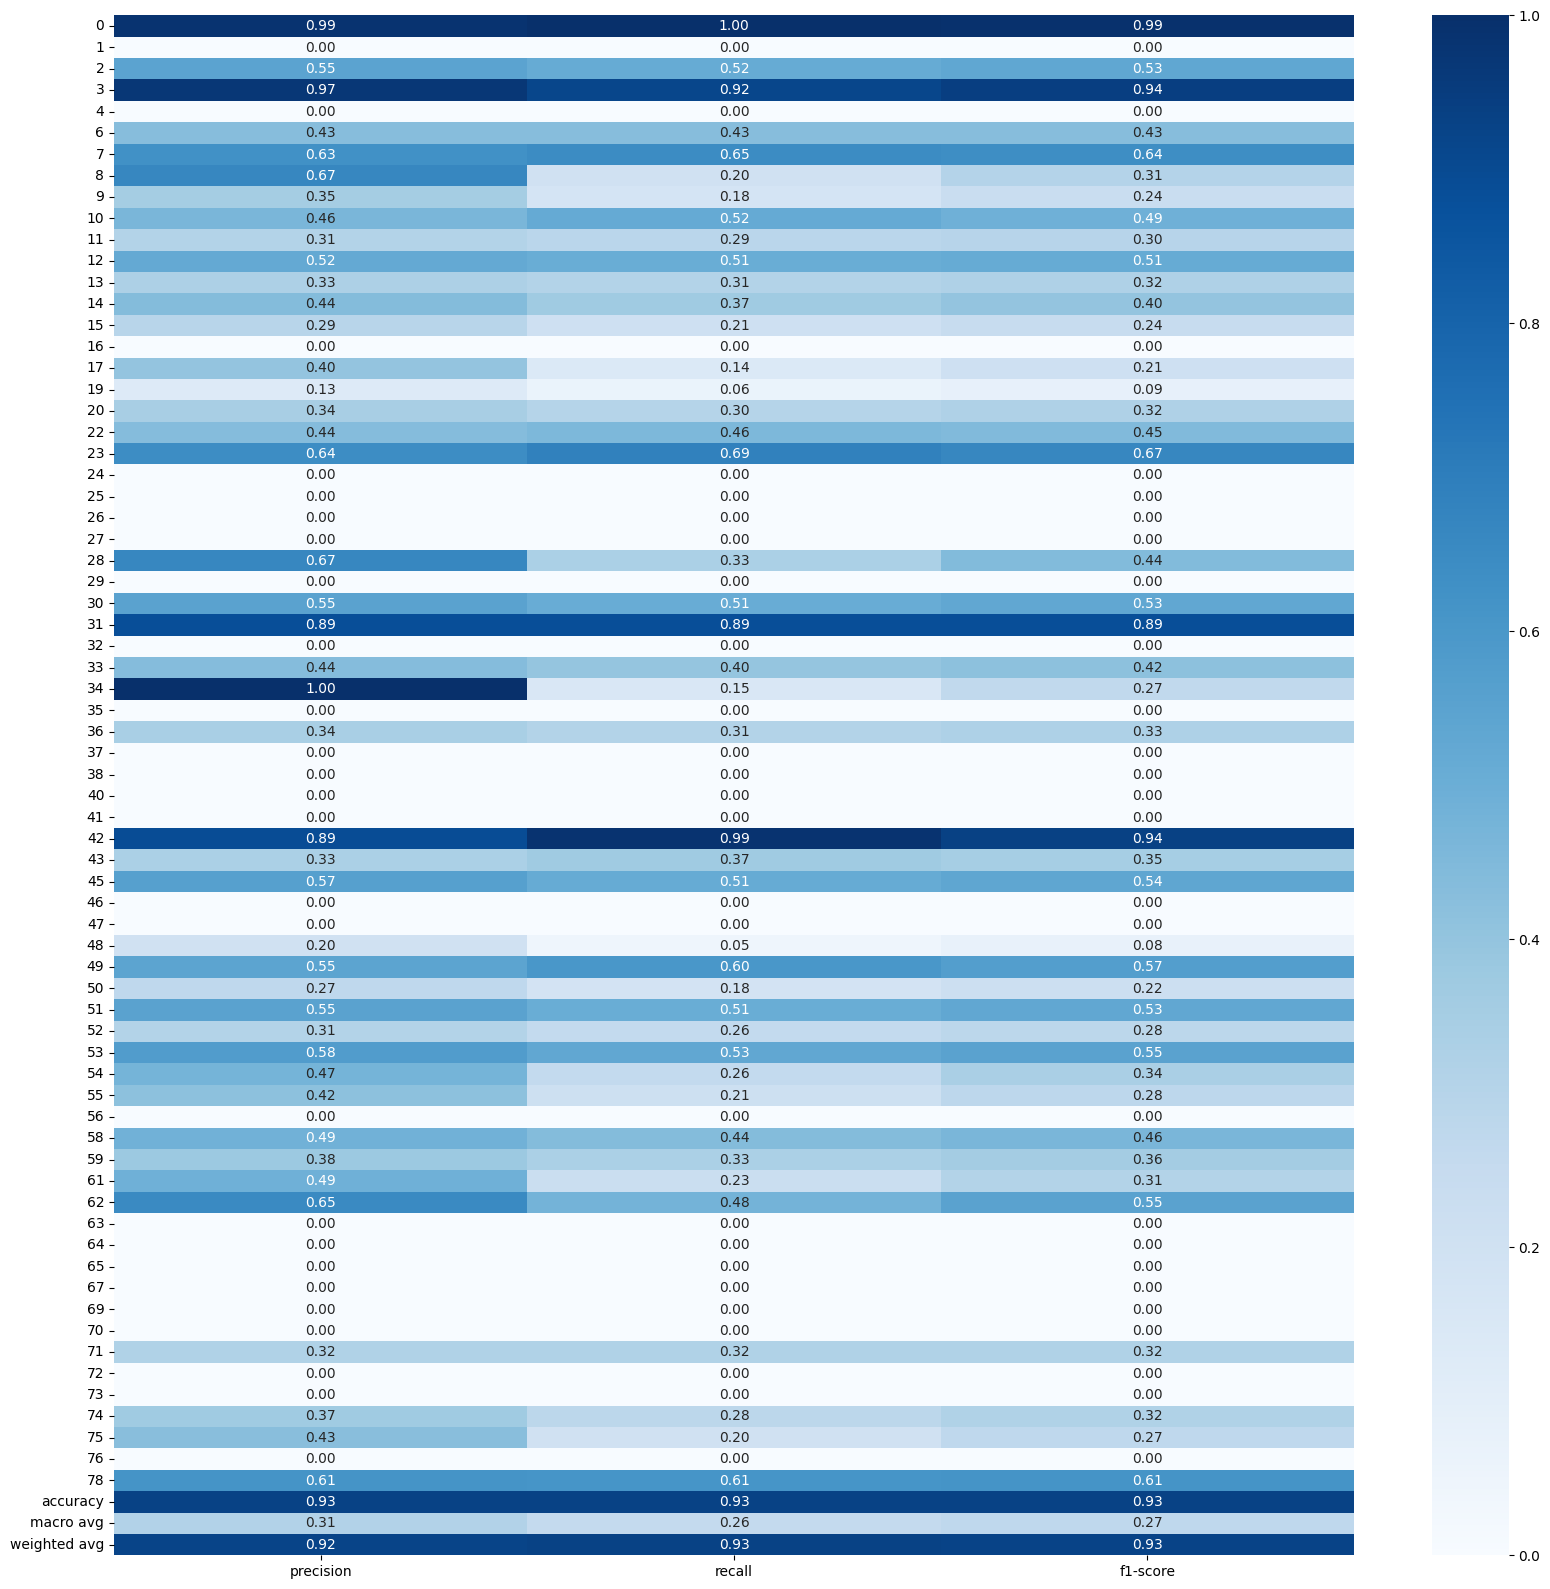

In [37]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(test_labels_labels.reshape(-1), y_pred_labels.reshape(-1), zero_division=0, output_dict=True)
plt.subplots(figsize=(20, 20))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.show()


In the case of NER task, all three metrics - precision, recall, and F1 score - are important.

* Precision measures the proportion of predicted entities that are actually correct. In NER, precision means how many of the predicted named entities are actually true named entities.

* Recall measures the proportion of actual entities that are correctly identified by the model. In NER, recall means how many true named entities are correctly identified by the model.

* F1 score is the harmonic mean of precision and recall. It is a balanced metric that takes into account both precision and recall. F1 score is commonly used in NER evaluation as it takes into account both false positives and false negatives.

A high precision score means that the model is making very few false predictions, while a high recall score means that the model is identifying a high proportion of the true named entities. A high F1 score indicates that the model is both precise and recallful.

In [16]:
# def clean_word(word):
    
#     # remove non-alphanumeric characters and extra whitespaces
#     word = re.sub(r'[^\w\s]','',word)
#     word = re.sub(r'\s+',' ',word)
    
#     # convert to lowercase
#     word = word.lower()
    
#     if word not in STOP_WORDS:
#         return word
    
#     return ''

# def tokenize_text(text):
#     # Tokenize the text into a list of words
#     tokens = []
#     for sentence in text.split('\n'):
#         for word in sentence.split():
#             word = clean_word(word)
#             if word.strip():
#                 tokens.append(word)
#     return tokens

# def predict(text):
    
#     sentences = re.split(r' *[\.\?!][\'"\)\]]* *', text)
#     sent_tokens = []
#     sequences = []
#     for sentence in sentences:
#         tokens = tokenize_text(sentence)
#         sequence = tokenizer.texts_to_sequences([' '.join(token for token in tokens)])
#         sequences.append(sequence[0])
#         sent_tokens.append(tokens)
        
#     padded_sequence = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

#     # tokens = re.findall(r'\b\w+\b', text)
# #     tokens = tokenize_text(text)
# #     sequence = tokenizer.texts_to_sequences([' '.join(token for token in tokens)])
# #     padded_sequence = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post')

#     # Make the prediction
#     prediction = model.predict(np.array(padded_sequence))

#     # Decode the prediction
#     predicted_labels = np.argmax(prediction, axis=-1)

#     predicted_labels = [[
#         index_to_label[i] for i in sent_predicted_labels]for sent_predicted_labels in predicted_labels]

# #     # Print the predicted named entities
#     print("Predicted Named Entities:")
#     for i in range(len(sent_tokens)):
#         for j in range(len(sent_tokens[i])):
#             if predicted_labels[i][j] == 'O':
#                 print(f"{sent_tokens[i][j]}: {predicted_labels[i][j]}")
#             else:
#                 print(f"{sent_tokens[i][j]}: {acronyms_to_entities[ predicted_labels[i][j][2:]]}")
#         print("\n\n\n")

## Save the model as an .h5 file

In [38]:
model.save(os.path.join(model_dir, 'model_1.h5'))

/Users/ajaykarthicksenthilkumar/miniconda/envs/ner_medical/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load the model 

In [13]:
# Register the custom metric function
tf.keras.utils.get_custom_objects()[precision.__name__] = precision
tf.keras.utils.get_custom_objects()[recall.__name__] = recall
tf.keras.utils.get_custom_objects()[f1_score.__name__] = f1_score

In [14]:
model_1 = tf.keras.models.load_model(os.path.join(model_dir, 'model_1.h5'))

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model_1.evaluate(test_sequences_padded, test_labels)

# Print the test loss and accuracy
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test f1_score:', test_f1_score)


28/28 [==============================] - 1s 18ms/step - loss: 0.4648 - accuracy: 0.9308 - precision: 0.9444 - recall: 0.9255 - f1_score: 0.9348
Test loss: 0.46480417251586914
Test accuracy: 0.9307824969291687
Test precision: 0.9443808794021606
Test recall: 0.9255045056343079
Test f1_score: 0.934843122959137


In [16]:
predict(
    "The patient underwent an electrophysiologic study with mapping of the accessory pathway, followed by radiofrequency ablation (interruption of the pathway using the heat generated by electromagnetic waves at the tip of an ablation catheter).",
    model_1, 
    index_to_label,
    acronyms_to_entities, 
    MAX_LENGTH
)



1/1 [==============================] - 0s 326ms/step
Predicted Named Entities:
patient: O
underwent: O
electrophysiologic: Sign_symptom
study: Diagnostic_procedure
mapping: Distance
accessory: Diagnostic_procedure
pathway: Lab_value
followed: Diagnostic_procedure
radiofrequency: Diagnostic_procedure
ablation: Lab_value
interruption: Lab_value
pathway: O
using: Lab_value
heat: Lab_value
generated: Diagnostic_procedure
electromagnetic: Diagnostic_procedure
waves: <PAD>
tip: <PAD>
ablation: <PAD>
catheter: <PAD>


In [17]:
predict(
    "A 57-year-old man presented to the emergency department with a 2-day history of worsening shortness of breath and chest pain. He reported no recent travel or sick contacts. His medical history was significant for hypertension, dyslipidemia, and type 2 diabetes mellitus. On examination, he was tachycardic and tachypneic, with oxygen saturation of 88% on room air. Chest radiography revealed bilateral opacities consistent with pulmonary edema. The patient was admitted to the intensive care unit for management of acute decompensated heart failure. He was started on intravenous diuretics and inotropic support with dobutamine. Over the next several days, his symptoms improved and he was discharged to home with instructions to follow up with his primary care provider in 1 week.",
    model_1, 
    index_to_label,
    acronyms_to_entities, 
    MAX_LENGTH
)

1/1 [==============================] - 0s 18ms/step
Predicted Named Entities:
57: O
year: Age
old: Age
man: O
presented: O
emergency: O
department: Duration
2: Duration
day: Duration
history: Sign_symptom
worsening: History
shortness: Sign_symptom
breath: Biological_structure
chest: O
pain: Biological_structure
reported: O
recent: O
travel: Duration
sick: O
contacts: Sign_symptom
medical: Sign_symptom
history: O
significant: Lab_value
hypertension: Detailed_description
dyslipidemia: O
type: Distance
2: Sign_symptom
diabetes: Lab_value
mellitus: O
examination: Lab_value
tachycardic: Sign_symptom
tachypneic: Distance
oxygen: O
saturation: Diagnostic_procedure
88: Diagnostic_procedure
room: Diagnostic_procedure
air: O
chest: O
radiography: O
revealed: O
bilateral: Diagnostic_procedure
opacities: O
consistent: Diagnostic_procedure
pulmonary: Diagnostic_procedure
edema: Diagnostic_procedure
patient: O
admitted: O
intensive: Biological_structure
care: O
unit: O
management: O
acute: O
decompe

In [20]:
predict_multi_line_text(
    
    "A 57-year-old man presented to the emergency department with a 2-day history of worsening shortness of breath and chest pain. He reported no recent travel or sick contacts. His medical history was significant for hypertension, dyslipidemia, and type 2 diabetes mellitus. On examination, he was tachycardic and tachypneic, with oxygen saturation of 88% on room air. Chest radiography revealed bilateral opacities consistent with pulmonary edema. The patient was admitted to the intensive care unit for management of acute decompensated heart failure. He was started on intravenous diuretics and inotropic support with dobutamine. Over the next several days, his symptoms improved and he was discharged to home with instructions to follow up with his primary care provider in 1 week.",
    model_1, 
    index_to_label,
    acronyms_to_entities, 
    MAX_LENGTH
    
)

1/1 [==============================] - 0s 23ms/step


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ajaykarthicksenthilkumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ajaykarthicksenthilkumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Predicted Named Entities:
57: O
year: Age
old: Age
man: O
presented: O
emergency: O
department: Duration
2: Duration
day: Duration
history: Sign_symptom
worsening: History
shortness: Sign_symptom
breath: Biological_structure
chest: <PAD>
pain: <PAD>




reported: O
recent: Biological_structure
travel: O
sick: <PAD>
contacts: <PAD>




medical: Lab_value
history: Date
significant: Diagnostic_procedure
hypertension: Sign_symptom
dyslipidemia: Sign_symptom
type: Diagnostic_procedure
2: Diagnostic_procedure
diabetes: Detailed_description
mellitus: O




examination: Biological_structure
tachycardic: Sign_symptom
tachypneic: Sign_symptom
oxygen: O
saturation: Sign_symptom
88: Sign_symptom
room: Sign_symptom
air: O




chest: Diagnostic_procedure
radiography: Diagnostic_procedure
revealed: Diagnostic_procedure
bilateral: O
opacities: O
consistent: Lab_value
pulmonary: <PAD>
edema: <PAD>




patient: O
admitted: Diagnostic_procedure
intensive: O
care: Diagnostic_procedure
unit: Diagnostic_pro